# Projeto de Geração Automática de Legendas para Imagens com Deep Learning - Image Caption

Neste notebook, vamos explorar um projeto de Deep Learning que visa gerar legendas automáticas para imagens. Esse é um exemplo fascinante de aplicação de Redes Neurais Convolucionais (CNNs) e Redes Neurais Recorrentes (RNNs) para combinar informações visuais e linguísticas. O código a seguir realiza todas as etapas do projeto.

A técnica de Image Caption (ou geração automática de legendas para imagens) é uma área fascinante de pesquisa em Visão Computacional e Processamento de Linguagem Natural (PLN) que combina o entendimento de imagens com a geração de linguagem natural. O objetivo é criar sistemas de IA que possam gerar descrições textuais significativas e humanamente compreensíveis para imagens, como se fossem legendas.

Os principais conceitos e etapas envolvidos na técnica de Image Caption:

**Extração de Recursos de Imagem**:
* Uma etapa fundamental na técnica de Image Caption é a extração de características relevantes das imagens. Isso geralmente é feito por meio de modelos de Redes Neurais Convolucionais (CNNs) pré-treinados, como VGG16, ResNet ou Inception. Esses modelos são capazes de capturar informações discriminativas das imagens, transformando-as em vetores de características.

**Processamento de Linguagem Natural (PLN)**:
* As legendas são representadas como sequências de palavras. Portanto, o texto precisa ser pré-processado e tokenizado para criar uma representação numérica das palavras. Isso envolve a remoção de pontuações, letras maiúsculas, divisão em palavras individuais e atribuição de um número único a cada palavra (vocabulário).

**Treinamento Supervisionado**:
* O modelo de Image Caption é treinado com um conjunto de dados que contém pares de imagens e legendas associadas. Durante o treinamento, o objetivo é minimizar a diferença entre as legendas geradas pelo modelo e as legendas reais do conjunto de treinamento. Isso é geralmente medido usando funções de perda, como a entropia cruzada.

**Avaliação Automática**:
A qualidade das legendas geradas é avaliada usando métricas automáticas, como BLEU (Bilingual Evaluation Understudy), METEOR, CIDEr, etc. Essas métricas comparam as legendas geradas pelo modelo com as legendas de referência (humanas) e atribuem uma pontuação com base na sobreposição de palavras e gramática.

**Geração de Legendas para Novas Imagens**:
* Uma vez treinado, o modelo pode ser usado para gerar legendas para novas imagens. Isso envolve a alimentação da imagem no Encoder e a geração de palavras sequencialmente pelo Decoder até que um símbolo de término seja previsto.

# Dataset

https://www.kaggle.com/datasets/adityajn105/flickr8k

In [3]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 18.0 MB/s eta 0:00:00


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!chmod 600 /content/kaggle.json


!kaggle datasets download -d adityajn105/flickr8k
!unzip /content/flickr8k.zip -d /content/kaggle/

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/kaggle/Images/2844846111_8c1cbfc75d.jpg  
  inflating: /content/kaggle/Images/2844963839_ff09cdb81f.jpg  
  inflating: /content/kaggle/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/kaggle/Images/2845691057_d4ab89d889.jpg  
  inflating: /content/kaggle/Images/2845845721_d0bc113ff7.jpg  
  inflating: /content/kaggle/Images/2846037553_1a1de50709.jpg  
  inflating: /content/kaggle/Images/2846785268_904c5fcf9f.jpg  
  inflating: /content/kaggle/Images/2846843520_b0e6211478.jpg  
  inflating: /content/kaggle/Images/2847514745_9a35493023.jpg  
  inflating: /content/kaggle/Images/2847615962_c330bded6e.jpg  
  inflating: /content/kaggle/Images/2847859796_4d9cb0d31f.jpg  
  inflating: /content/kaggle/Images/2848266893_9693c66275.jpg  
  inflating: /content/kaggle/Images/2848571082_26454cb981.jpg  
  inflating: /content/kaggle/Images/2848895544_6d06210e9d.jpg  
  inflating: /content/kaggle/Images/284897704

# Importação de Bibliotecas e Configuração do Ambiente

O código começa importando as bibliotecas necessárias, incluindo NumPy, Pandas, TensorFlow, Keras e outras. Além disso, é preciso configurar o ambiente de trabalho, como o diretório de trabalho e a configuração de GPUs disponíveis.

In [5]:
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from textwrap import wrap
from urllib.request import urlopen
from PIL import Image
from nltk.translate.bleu_score import corpus_bleu

import warnings
warnings.filterwarnings('ignore')

os.chdir('/content/kaggle')
os.listdir()

['Images', 'captions.txt']

In [6]:
import tensorflow as tf
from tensorflow import keras
print(f"Tensorflow Version: {tf.__version__}")
print(f"Number of GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

# necessary preprocessing libraries:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Flatten, add
import visualkeras


Tensorflow Version: 2.13.0
Number of GPUs Available: 1


In [7]:
# defining directories:
BASE_DIR = '/content/kaggle'
WORKING_DIR = '/content'

# Carregamento de Dados

Nesta etapa, é preciso carregar um arquivo chamado 'captions.txt', que contém informações sobre as imagens e suas legendas. Através do arquivo cria-se um DataFrame com esses dados e mantém apenas a primeira legenda para cada imagem, agrupando os dados por imagem.

In [8]:
# import dataset of labels
temp_df = pd.read_csv(os.path.join(BASE_DIR,'captions.txt'))
temp_df = temp_df.groupby('image').first().reset_index()
temp_df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
2,1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o...
3,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .
4,1007129816_e794419615.jpg,A man in an orange hat starring at something .
...,...,...
8086,990890291_afc72be141.jpg,A man does a wheelie on his bicycle on the sid...
8087,99171998_7cc800ceef.jpg,A group is sitting around a snowy crevasse .
8088,99679241_adc853a5c0.jpg,A grey bird stands majestically on a beach whi...
8089,997338199_7343367d7f.jpg,A person stands near golden walls .


# Visualização de Dados

Cria-se uma função chamada `display_images` é definida para exibir imagens com suas respectivas legendas. Essa função lê imagens da pasta 'Images' e exibe uma seleção delas.

In [9]:
def display_images(temp_df):
    def readImage(path, img_size=224):
        img = load_img(path, color_mode='rgb',target_size=(img_size, img_size))
        img = img_to_array(img)
        img = img/255.
        return img

    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(5):
        n+=1
        plt.subplot(5,5,n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(os.path.join(BASE_DIR,'Images',temp_df['image'].iloc[i]))
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df['caption'].iloc[i], 20)))
        plt.axis("off")

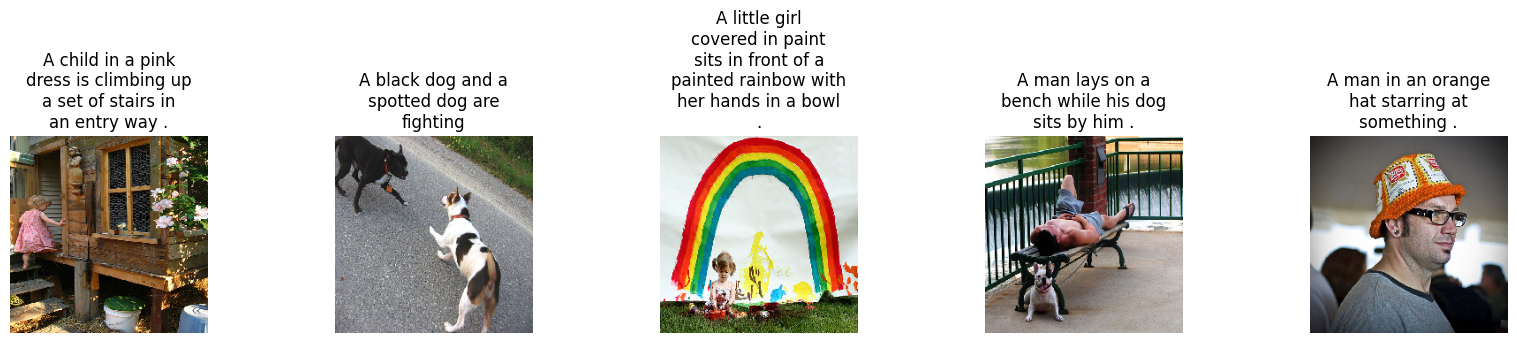

In [10]:
display_images(temp_df)

# Extração de Recursos de Imagem

A partir deste ponto, o código começa a trabalhar com a extração de recursos de imagem. Utiliza-se o modelo VGG16 pré-treinado para extrair características das imagens. Esses recursos são extraídos para todas as imagens na pasta 'Images' e armazenados em um dicionário chamado 'features'.

In [11]:
%%time

img_model = VGG16()
# Reorganizar o modelo (exclua a última camada densa):
img_model = Model(inputs = img_model.inputs, outputs = img_model.layers[-2].output)

display(img_model.summary())

553467096/553467096 [==============================] - 6s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

None

CPU times: user 4.05 s, sys: 2.73 s, total: 6.79 s
Wall time: 13 s


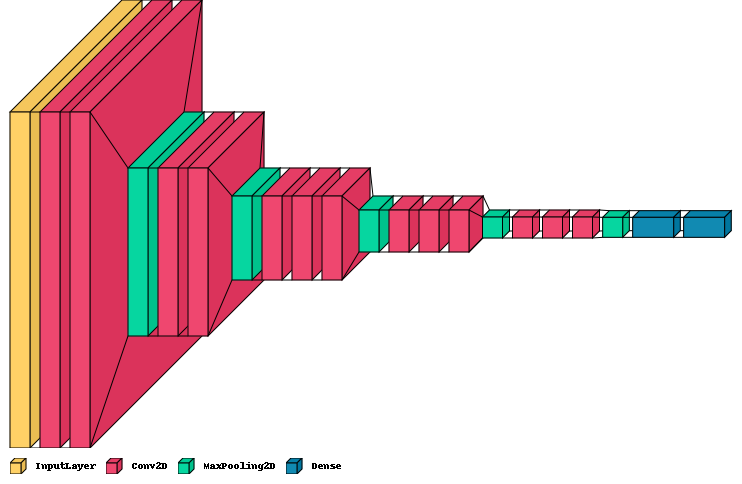

In [12]:
# visualize VGG16 (img_model):
visualkeras.layered_view(img_model, draw_volume=True, scale_xy=1.5,scale_z=0.01, legend=True, type_ignore=[Flatten,Dropout])

In [14]:
%%time

# função para extração de recursos de imagens:
def feature_extraction(model, path):
    features = {}
    img_size = 224

    for img_name in tqdm(os.listdir(path)):
        img_path = os.path.join(path, img_name)
        # ler a imagem do arquivo
        img = load_img(img_path, target_size=(img_size, img_size))
        # converter imagem em numpy array
        img = img_to_array(img)
        # reshape e pre-processo  das imagens para o modelo
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        # extrair features (caracteristicas)
        feature = model.predict(img, verbose=1)
        # Pegar o ID da imagem:
        img_id = img_name.split('.')[0]
        # armazenar a feature extraida
        features[img_id]=feature
    return features

path = os.path.join(BASE_DIR,'Images')
features = feature_extraction(img_model,path)

  0%|          | 0/8091 [00:00<?, ?it/s]

A saída de streaming foi truncada nas últimas 5000 linhas.
1/1 [==============================] - 0s 23ms/step
CPU times: user 10min 29s, sys: 17.6 s, total: 10min 47s
Wall time: 13min 10s


In [15]:
# Salvando as features em um dicionario
with open (os.path.join(WORKING_DIR,'features_dict.pkl'),'wb') as f:
    pickle.dump(features,f)

In [16]:
df = pd.read_csv(os.path.join(BASE_DIR,'captions.txt'))
df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


# Pré-processamento de Texto

A função clean_txt remove URLs, símbolos e realiza outras etapas de pré-processamento.

In [17]:
# Função para limpeza do texto
def clean_txt(text):
    import re
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub('#\S+','',text)
    text = re.sub(r'@\S+','', text)
    text = re.sub(r'[^A-Za-z]+',' ',text)
    text = re.sub(r'\s+',' ',text)
    text = 'stseq '+' '.join([word for word in text.split() if len(word)>1])+' enseq'
    return text

# example:
txt = 'A child in a PINK dress is climbing up a set of stairs in an entry #new_ways'
new_txt = clean_txt(txt)
new_txt

'stseq child in pink dress is climbing up set of stairs in an entry enseq'

# Criação de um Dicionário de Legendas

Cria-se um dicionário que mapeia o nome da imagem para suas legendas após o pré-processamento.

In [18]:
%%time
# função para limpar legendas e criar dicionario para mapear o nome da imagem para legendas
def store_captions(data):
    captions={}
    for img_name,caption in tqdm(data.values):
        name = img_name.split('.')[0]
        if name not in captions:
            captions[name]=[] # uma imagem pode ter várias legendas
        captions[name].append(clean_txt(caption))
    return captions

captions = store_captions(df)


  0%|          | 0/40455 [00:00<?, ?it/s]

CPU times: user 646 ms, sys: 6.81 ms, total: 653 ms
Wall time: 664 ms


In [19]:
captions['1000268201_693b08cb0e']

['stseq child in pink dress is climbing up set of stairs in an entry way enseq',
 'stseq girl going into wooden building enseq',
 'stseq little girl climbing into wooden playhouse enseq',
 'stseq little girl climbing the stairs to her playhouse enseq',
 'stseq little girl in pink dress going into wooden cabin enseq']

In [20]:
# Salvar as captions como dicionario
with open (os.path.join(WORKING_DIR,'captions.pkl'),'wb') as f:
    pickle.dump(captions,f)

# Tokenização de Texto

As legendas são tokenizadas e um tokenizador é criado. O tamanho do vocabulário e o comprimento máximo de uma legenda são calculados.

In [21]:
# Criação do corpus:
corpus=[]
for img,data in captions.items():
    for line in data:
        corpus.append(line)

len(corpus)

40455

In [22]:
# Checando o corpus:
corpus[:10]

['stseq child in pink dress is climbing up set of stairs in an entry way enseq',
 'stseq girl going into wooden building enseq',
 'stseq little girl climbing into wooden playhouse enseq',
 'stseq little girl climbing the stairs to her playhouse enseq',
 'stseq little girl in pink dress going into wooden cabin enseq',
 'stseq black dog and spotted dog are fighting enseq',
 'stseq black dog and tri colored dog playing with each other on the road enseq',
 'stseq black dog and white dog with brown spots are staring at each other in the street enseq',
 'stseq two dogs of different breeds looking at each other on the road enseq',
 'stseq two dogs on pavement moving toward each other enseq']

In [23]:
# Tokenizar o texto
tok = Tokenizer()
tok.fit_on_texts(corpus)

vocab_size = len(tok.word_index)+1
print(f"Vocab size: {vocab_size}")

Vocab size: 8427


In [24]:
# get max length of the captions:
max_len = max(len(cap.split()) for cap in corpus)
print(max_len)

35


# Divisão de Dados de Treinamento e Teste

As imagens são divididas em conjuntos de treinamento e teste.

In [25]:
img_id = list(captions.keys())
split = int(len(img_id)*0.9)

train = img_id[:split]
test = img_id[split:]

print(len(train))
print(len(test))

7281
810


# Gerador de Dados

Define-se uma função geradora de dados para criar lotes de dados durante o treinamento do modelo. Isso ajuda a evitar problemas de memória.

In [26]:
# criar uma função geradora de dados para obter dados em lote (evitar travamento da sessão colab)
# este gerador de dados irá tokenizar e preencher as legendas em si
def dataGenerator(data_keys, captions, features, tokenizer, max_len, vocab_size, batch_size):
    # loop sobre as imagens
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key in data_keys:
            n+=1
            data = captions[key]
            for caption in data:
                # encode da sequencia
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split a seq entre X, y
                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input seq:
                    in_seq = pad_sequences([in_seq], maxlen=max_len, padding='post')[0]
                    # encode output seq:
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # armazenar da sequencias
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==batch_size:
                X1, X2, y = np.array(X1),np.array(X2),np.array(y)
                yield [X1,X2],y
                X1,X2,y = list(),list(),list()
                n=0

# Criação do Modelo

Essa etapa envolve a definição da arquitetura do modelo de aprendizado profundo que traduzirá as características da imagem em uma legenda descritiva. O modelo é geralmente construído em três partes distintas:

* **Características da imagem (extraídas do VGG16)**:
  * A primeira parte do modelo lida com as características da imagem. Essas características são extraídas usando um modelo de rede neural convolucional (CNN) pré-treinado, como VGG16, ResNet ou Inception. O objetivo é transformar a imagem em um vetor de características com informações relevantes para a geração de legenda.
  * Nessa parte reduz a dimensionalidade das características da imagem e captura informações importantes, como objetos, formas e contexto visual. O resultado é um vetor (ou matriz) que representa o conteúdo da imagem.
* **Características da sequência (legendas)**:
  * A segunda parte, muitas vezes chamada de "Context" (ou Contexto), é responsável por transformar o vetor de características da imagem em um vetor de contexto. Esse vetor de contexto é uma representação abstrata que combina as informações da imagem e servirá como entrada decodificação da imagem
  
* **Decodificação e previsão das próximas palavras na legenda**:
  * A terceira parte do modelo é responsável por gerar a sequência de palavras que compõem a legenda. Essa parte geralmente uma Rede Neural Recorrente (RNN), como uma Long Short-Term Memory (LSTM) ou uma Gated Recurrent Unit (GRU).
  * A decodificação gera palavras sequencialmente, começando com um token especial de início (geralmente "<start>") e continuando até que um token de fim (geralmente "<end>") seja previsto ou até que um comprimento máximo seja atingido.
  * Cada passo de tempo a decodificação leva em consideração a palavra previamente gerada e o vetor de contexto do Encoder para prever a próxima palavra na sequência. A previsão é feita usando uma camada de saída que normalmente possui uma função de ativação softmax para gerar uma distribuição de probabilidade sobre o vocabulário de palavras.



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 35, 256)              2157312   ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 4096)                 0         ['input_2[0][0]']             
                                                                                            

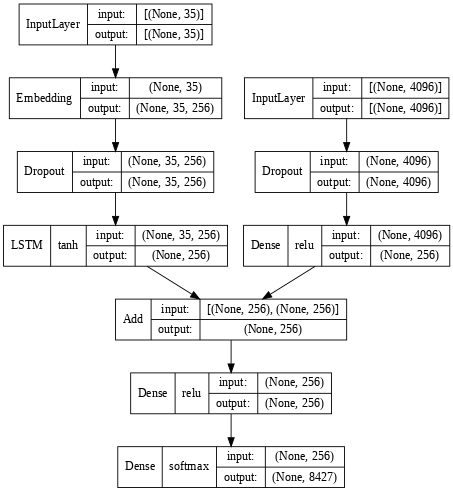

In [27]:
%%time
# encoder model:

# image feature layers
input1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(input1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
input2 =Input(shape=(max_len,))
se1 = Embedding(vocab_size,256,mask_zero=True)(input2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)


# decoder model
decoder1 = add([fe2,se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input1,input2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# show summary
print(model.summary())

# plot the model
os.chdir(WORKING_DIR)
plot_model(model, show_shapes=True, show_layer_names=False, show_layer_activations=True, dpi=64)

# Treinamento do Modelo

O modelo é treinado usando os dados de treinamento, com um callback para interromper o treinamento antecipadamente se a perda não melhorar.

In [28]:
%%time
# Treinando o model:
epochs = 20
batch_size = 32
steps = len(train)//batch_size

callback= keras.callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=4)

for i in range(epochs):
    data = dataGenerator(train,captions,features,tok,max_len,vocab_size,batch_size)
    model.fit(data, epochs=1, steps_per_epoch=steps,verbose=1,callbacks=[callback])

227/227 [==============================] - 48s 212ms/step - loss: 2.1806
CPU times: user 13min 5s, sys: 3min 57s, total: 17min 2s
Wall time: 21min 5s


In [29]:
model.save('model1.h5')

In [30]:
def predict_captions(model,image_feature,tokenizer,max_len):
    def int_to_word(integer,tokenizer):
        for word,val in tokenizer.word_index.items():
            if val==integer:
                return word
        return None
    in_text = 'stseq'
    for i in range(max_len):
        seq = tok.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq],maxlen=max_len)
        yhat = model.predict([image_feature,seq], verbose=0)
        yhat = np.argmax(yhat)
        word = int_to_word(yhat,tokenizer)
        if word is None:
            break;
        in_text+=" "+word;
        if word=='enseq':
            break;
    return in_text

# Avaliação do Modelo

O código avalia o modelo usando o conjunto de teste e calcula o BLEU score para avaliar a qualidade das legendas geradas em relação às legendas reais.

In [31]:
%%time
# validar com test data:
actual, predicted = list(), list()

for key in tqdm(test[:20]):
    text = captions[key]
    actual_captions = [caption.split() for caption in text]
    y_pred = predict_captions(model,features[key],tok,max_len)
    predicted_captions = y_pred.split()

    actual.append(actual_captions)
    predicted.append(predicted_captions)

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 17.3 s, sys: 442 ms, total: 17.7 s
Wall time: 20.1 s


O BLEU score é uma métrica de avaliação automática amplamente utilizada para medir a qualidade das legendas geradas por um modelo de Image Caption em relação às legendas de referência (geradas por humanos). O objetivo do BLEU score é quantificar o quão bem as legendas geradas pelo modelo coincidem com as legendas humanas de referência.

**actual**: Esta variável contém as legendas de referência reais (humanas) para as imagens no conjunto de teste. É uma lista de listas, onde cada sublista contém as palavras de uma legenda de referência.

**predicted**: Esta variável contém as legendas geradas pelo modelo para as mesmas imagens no conjunto de teste. É uma lista de listas, onde cada sublista contém as palavras da legenda gerada.

**weights**: Os pesos são usados para determinar o peso relativo das várias métricas de precisão de palavras no cálculo do BLEU score. No código, dois pesos são usados: (1.0, 0, 0, 0) para BLEU-1 e (0.5, 0.5, 0, 0) para BLEU-2.

  * **BLEU-1** (ou unigram BLEU) usa apenas unigramas (palavras individuais) para calcular a precisão.

  * **BLEU-2** (ou bigram BLEU) leva em consideração a precisão de bigramas (pares de palavras consecutivas) além de unigramas.

In [32]:
# Calcular o BLEU score:
print(f"BLEU-1: {corpus_bleu(actual,predicted,weights=(1.0 ,0, 0, 0))}")
print(f"BLEU-2: {corpus_bleu(actual,predicted,weights=(0.5, 0.5 0, 0))}")

BLEU-1: 0.5151515151515151
BLEU-2: 0.2923211814586795


In [33]:
def get_captions(path):
    from PIL import Image
    img_id = path.split('/')[-1]
    img_id = img_id.split('.')[0]
    print(img_id)
    image = Image.open(path)
    data = captions[img_id]
    print('------------------Real------------------')
    for caption in data:
        print(caption)
    y_pred = predict_captions(model,features[img_id],tok,max_len)
    print('------------------Predita------------------')
    print(y_pred)
    plt.imshow(image)
    plt.axis('off')

1016887272_03199f49c4
------------------Real------------------
stseq collage of one person climbing cliff enseq
stseq group of people are rock climbing on rock climbing wall enseq
stseq group of people climbing rock while one man belays enseq
stseq seven climbers are ascending rock face whilst another man stands holding the rope enseq
stseq several climbers in row are climbing the rock while the man in red watches and holds the line enseq
------------------Predita------------------
stseq three climbers are climbing up rock wall enseq


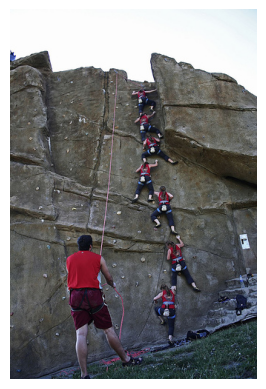

In [34]:
get_captions('/content/kaggle/Images/1016887272_03199f49c4.jpg')

1007320043_627395c3d8
------------------Real------------------
stseq child playing on rope net enseq
stseq little girl climbing on red roping enseq
stseq little girl in pink climbs rope bridge at the park enseq
stseq small child grips onto the red ropes at the playground enseq
stseq the small child climbs on red ropes on playground enseq
------------------Predita------------------
stseq little girl climbing red roping enseq


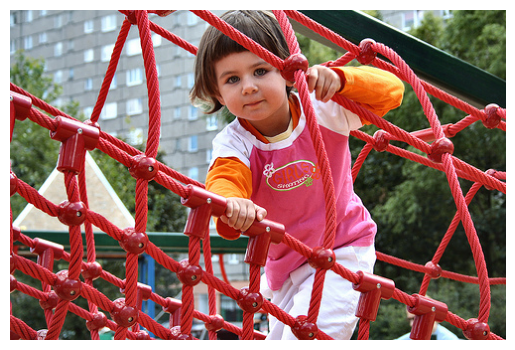

In [35]:
get_captions('/content/kaggle/Images/1007320043_627395c3d8.jpg')

# Geração de Legendas para Novas Imagens

Função para gerar legendas automáticas para imagens fornecidas por URL. Para isso usa-se o modelo treinado e as características da imagem para gerar legendas.

In [36]:
def generate_captions_from_URL(path ,CNN, main_model, tokenizer, max_len):
    img_path = path
    image_url = tf.keras.utils.get_file(origin=path )
    img = load_img(image_url, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    feature = CNN.predict(img, verbose=0)

    def int_to_word(integer,tokenizer):
        for word,val in tokenizer.word_index.items():
            if val==integer:
                return word
        return None
    in_text = 'stseq'
    for i in range(max_len):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq],maxlen=max_len)
        yhat = model.predict([feature,seq], verbose=0)
        yhat = np.argmax(yhat)
        word = int_to_word(yhat,tokenizer)
        if word is None:
            break;
        in_text+=" "+word;
        if word=='enseq':
            break;

    plt.imshow(Image.open(urlopen(path)))
    plt.title(in_text)
    plt.axis('off')
    plt.show()

10839/10839 [==============================] - 0s 0us/step


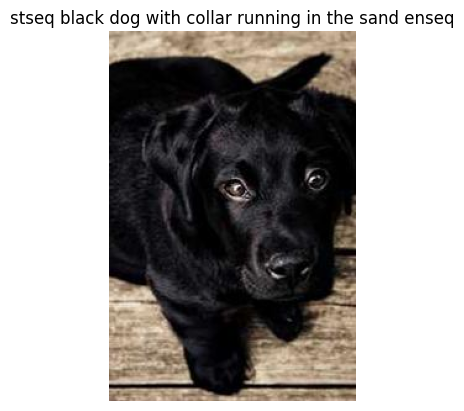

In [37]:
generate_captions_from_URL(path='https://picsum.photos/id/237/200/300',
                  CNN=img_model, main_model=model, tokenizer=tok,max_len=40)

2126411/2126411 [==============================] - 0s 0us/step


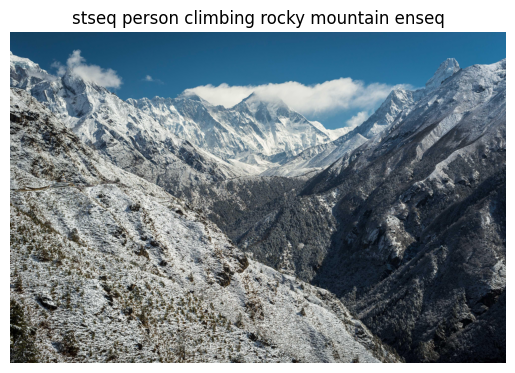

In [38]:
generate_captions_from_URL(path='https://fastly.picsum.photos/id/29/4000/2670.jpg?hmac=rCbRAl24FzrSzwlR5tL-Aqzyu5tX_PA95VJtnUXegGU',
                  CNN=img_model, main_model=model, tokenizer=tok, max_len=40)

226933/226933 [==============================] - 0s 0us/step


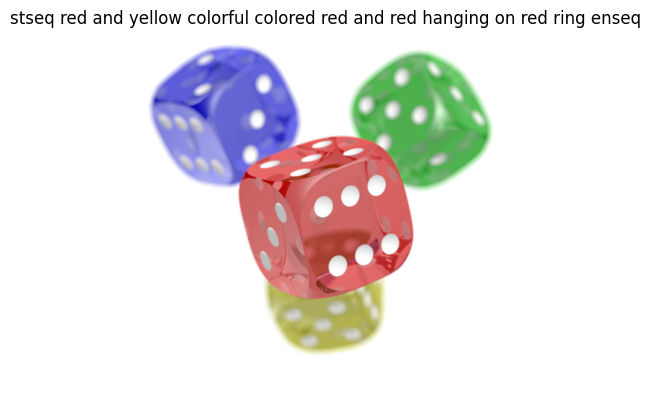

In [40]:
image_url = 'https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png'

generate_captions_from_URL(image_url, img_model, model, tok, max_len)
